In [119]:
import json
import pickle
import numpy as np
import pandas as pd
import os.path as op
import itertools as it
from utilities import files
from mne import read_epochs
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from extra.tools import many_is_in, cat, shuffle_array, shuffle_array_range, consecutive_margin_ix, dump_the_dict

In [5]:
waveform_subset_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/waveforms_clean_subset_fit.npy"
scaler_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/scaler_MEG.pkl"
PCA_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_solution_MEG.pkl"
dataset = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/sub_metrics.pkl"

In [30]:
visual_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-visual-epo.fif"
motor_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-motor-epo.fif"
visual_epoch = read_epochs(visual_epoch_file, verbose=False)
motor_epoch = read_epochs(motor_epoch_file, verbose=False)
visual_epoch_times = visual_epoch.times
motor_epoch_times = motor_epoch.times

In [31]:
buffer = 0.125
bin_width=0.05
baseline_range = [-0.5, 0]


visual_time_bins = np.arange(visual_epoch_times[0] + buffer, visual_epoch_times[-1] - buffer, bin_width)
motor_time_bins = np.arange(motor_epoch_times[0] + buffer, motor_epoch_times[-1] - buffer, bin_width)

visual_bin_ranges = list(zip(visual_time_bins[:-1], visual_time_bins[1:]))
motor_bin_ranges = list(zip(motor_time_bins[:-1], motor_time_bins[1:]))
vis_time_plot = visual_time_bins[:-1]
mot_time_plot = motor_time_bins[:-1]

In [6]:
waveforms_clean = np.load(waveform_subset_path)
scaler_meg = pickle.load(open(scaler_path, "rb"))
PCA_saved = pickle.load(open(PCA_path, "rb"))
sub_metrics = pickle.load(open(dataset, "rb"))

In [77]:
shuffled_var_exp_ratio_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/shuffled_var_exp_ratio.npy"
pca_vars = np.load(shuffled_var_exp_ratio_file)
shuffling_results = np.mean(np.vstack([i <= PCA_saved.explained_variance_ratio_ for i in pca_vars]), axis=0)

In [51]:
pickle_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/PC_score_in_time.pkl"

if op.exists(pickle_file):
    PC_score_in_time = pickle.load(open(pickle_file, "rb"))
else:
    PC_score_in_time = {sub: {
       ep: {
          "PC_{}".format(pc+1) : [] for pc in range(20)
       } for ep in ["mot", "vis"] 
    } for sub in sub_metrics.keys()}

    for sub in tqdm(sub_metrics.keys()):
        for ep in sub_metrics[sub].keys():
            wvf = scaler_meg.transform(sub_metrics[sub][ep]["waveform"])
            sub_metrics[sub][ep]["PC_score"] = PCA_saved.transform(wvf)
            for pc_ix in range(20):
                pc_key = "PC_{}".format(pc_ix+1)
                for tr in np.unique(sub_metrics[sub][ep]["pp_ix"]):
                    if ep == "vis":
                        bin_ranges = visual_bin_ranges
                    elif ep == "mot":
                        bin_ranges = motor_bin_ranges
                    tri_tc = []
                    for st, en in bin_ranges:
                        tr_ix = np.where(
                            (sub_metrics[sub][ep]["peak_time"] >= st) &
                            (sub_metrics[sub][ep]["peak_time"] <= en) &
                            (sub_metrics[sub][ep]["pp_ix"] == tr)
                        )[0]
                        res = np.nanmean(sub_metrics[sub][ep]["PC_score"][tr_ix, pc_ix])
                        tri_tc.append(res)
                    tri_tc = np.array(tri_tc)
                    PC_score_in_time[sub][ep][pc_key].append(tri_tc)

    pickle.dump(PC_score_in_time, open(pickle_file, "wb"))

  0%|          | 0/37 [00:00<?, ?it/s]

In [56]:
np.mean(PC_score_in_time["sub-101"]["vis"]["PC_1"]).shape

(448, 54)

In [59]:
PC_mean_score_in_time = {
       ep: {
          "PC_{}".format(pc+1) : [] for pc in range(20)
       } for ep in ["mot", "vis"] 
    }

for sub in PC_score_in_time.keys():
    for ep in PC_score_in_time[sub].keys():
        for pc_key in PC_score_in_time[sub][ep].keys():
            data = np.vstack(PC_score_in_time[sub][ep][pc_key])
            data = np.nanmean(data, axis=0)
            PC_mean_score_in_time[ep][pc_key].append(data)

In [61]:
PC_mean_variance_of_score_in_time = {ep: [] for ep in ["mot", "vis"]}

for ep in PC_mean_score_in_time.keys():
    for pc_ix in PC_mean_score_in_time[ep].keys():
        data = np.vstack(PC_mean_score_in_time[ep][pc_ix])
        data = np.var(np.mean(data, axis=0))
        PC_mean_variance_of_score_in_time[ep].append(data)

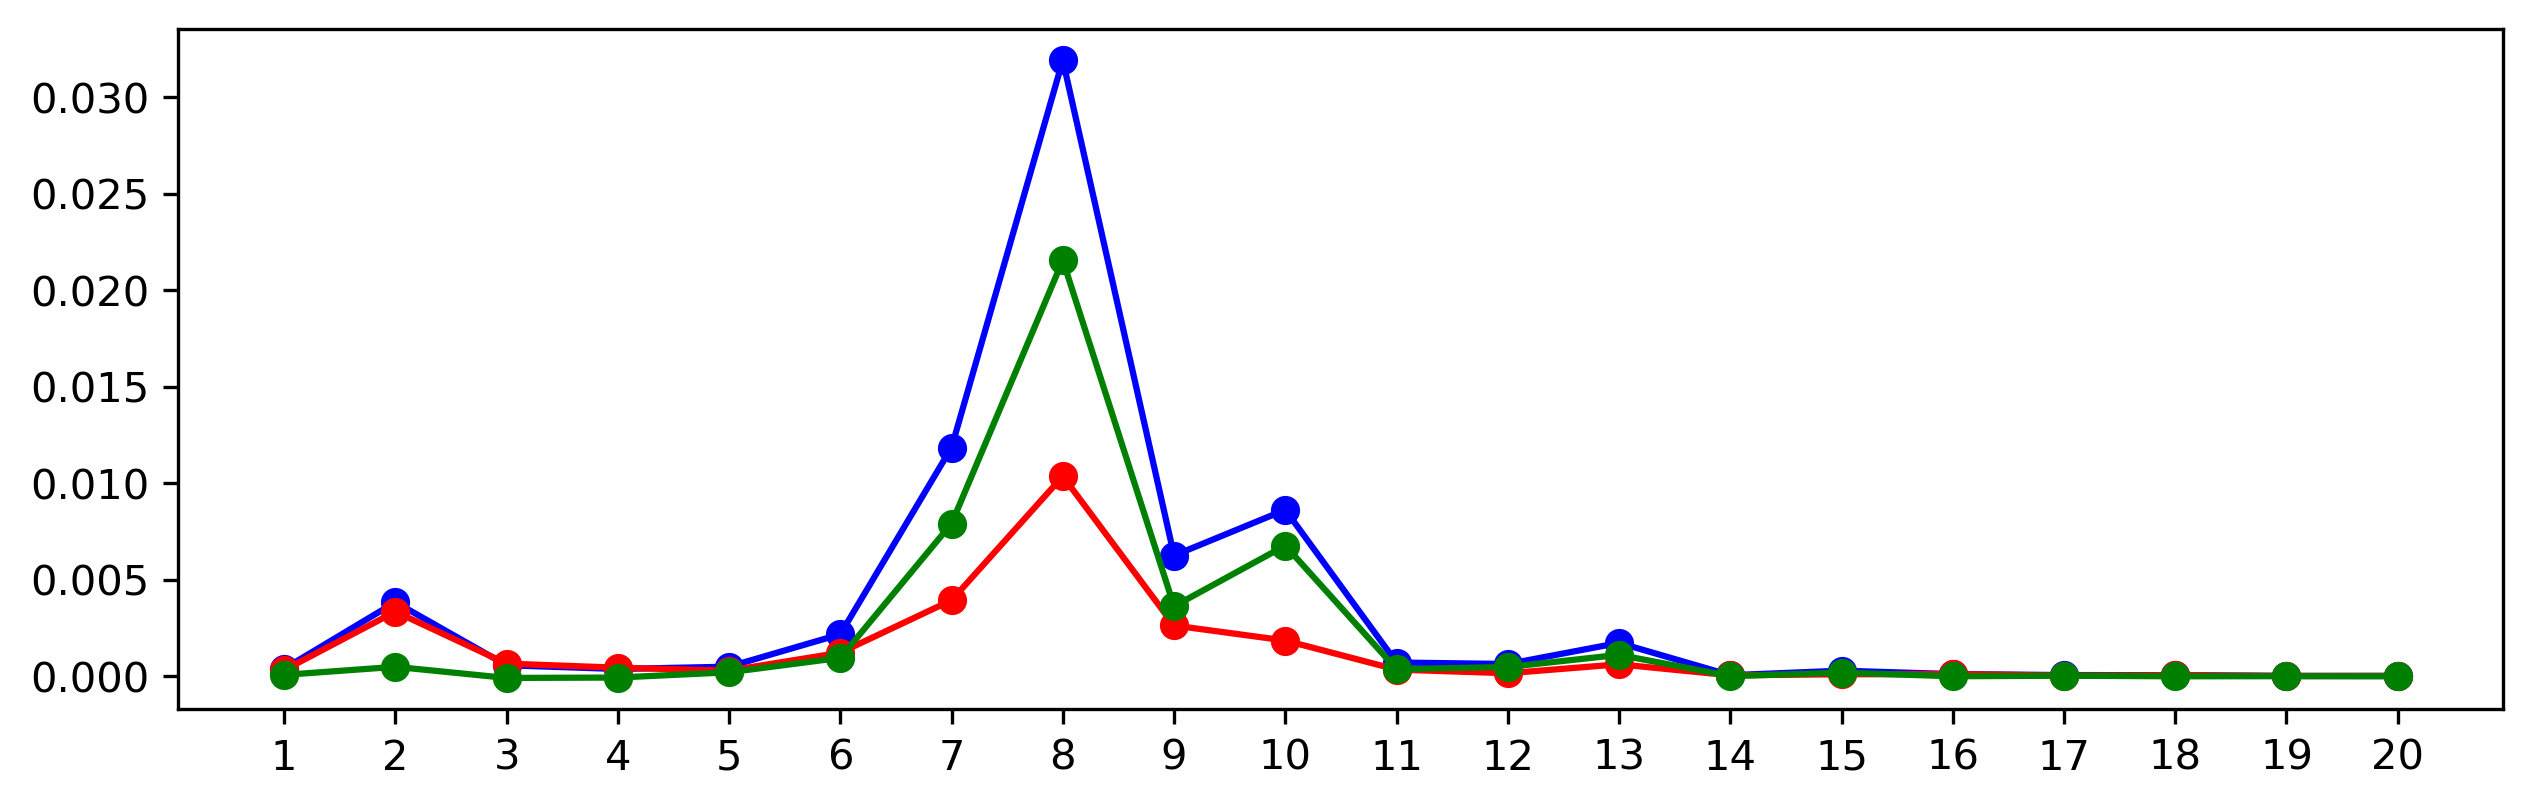

In [76]:
f, ax = plt.subplots(1, 1, figsize=(10,3), dpi=300, facecolor="white")
pc_range = np.arange(20) + 1
ax.scatter(pc_range, PC_mean_variance_of_score_in_time["mot"], color="blue", zorder=1)
ax.plot(pc_range, PC_mean_variance_of_score_in_time["mot"], color="blue", zorder=1)
ax.scatter(pc_range, PC_mean_variance_of_score_in_time["vis"], color="red", zorder=2)
ax.plot(pc_range, PC_mean_variance_of_score_in_time["vis"], color="red", zorder=2)
ax.scatter(pc_range, np.array(PC_mean_variance_of_score_in_time["mot"]) - np.array(PC_mean_variance_of_score_in_time["vis"]), color="green", zorder=3)
ax.plot(pc_range, np.array(PC_mean_variance_of_score_in_time["mot"]) - np.array(PC_mean_variance_of_score_in_time["vis"]), color="green", zorder=3)
ax.set_xticks(pc_range);


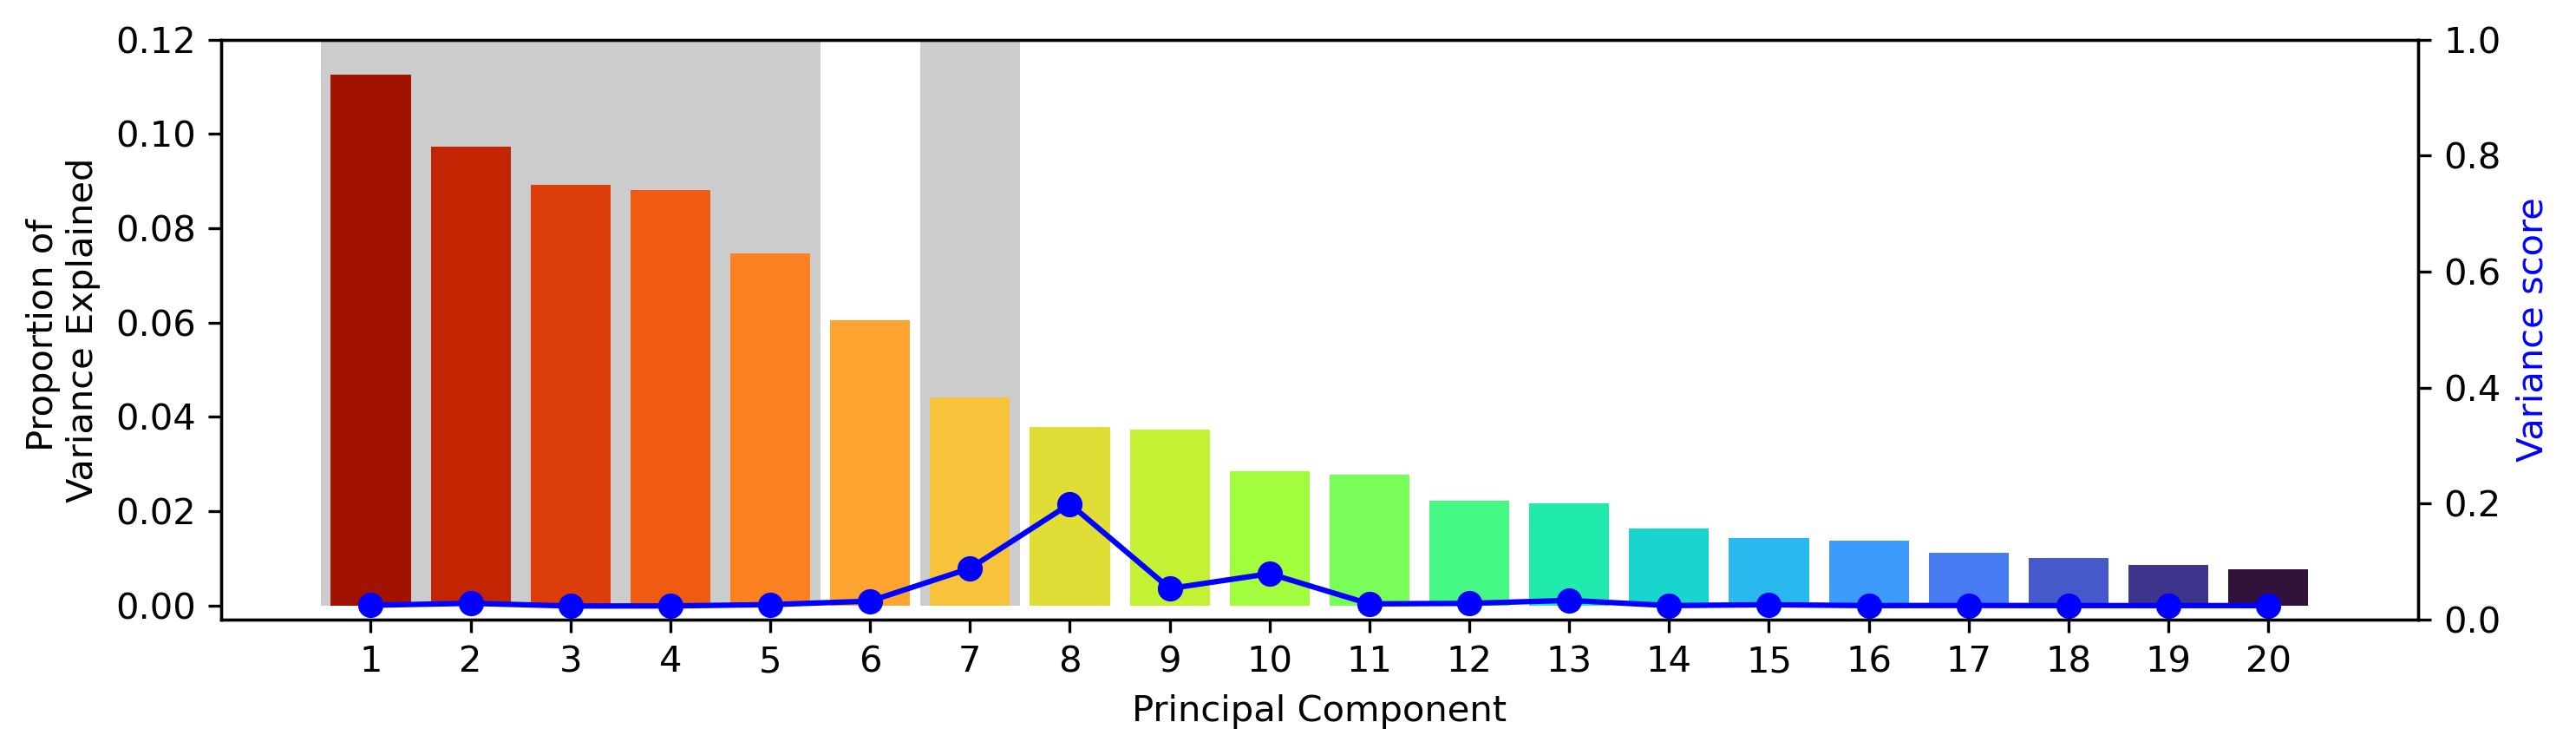

In [93]:
f, ax = plt.subplots(1, 1, figsize=(10,3), dpi=300, facecolor="white")
PC_var_exp = PCA_saved.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
bar = ax.bar(PC_r, shuffling_results, lw=0.2, color="black", alpha=0.2, width=1)
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))

ax.scatter(PC_r, (np.array(PC_mean_variance_of_score_in_time["mot"]) - np.array(PC_mean_variance_of_score_in_time["vis"])), color="blue", zorder=10)
ax.plot(PC_r, (np.array(PC_mean_variance_of_score_in_time["mot"]) - np.array(PC_mean_variance_of_score_in_time["vis"])), color="blue", zorder=10)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
ax.set_xticks(PC_r)
ax.set_ylim(-0.003, 0.12)
ax2 = ax.twinx()
ax2.set_ylabel("Variance score", color="blue")
plt.tight_layout();

In [122]:
# stacking all metrics
pc_list = ["PC_{}".format(pc+1) for pc in range(20)]
sel_list = ["subject", "epoch"]
imp_features = ['peak_time', 'peak_freq', 'peak_amp_base', 'fwhm_freq', 'fwhm_time', 'trial', 'pp_ix', 'block']
waveform_array = []

data_frame_dict = {
    i: [] for i in sel_list + imp_features + pc_list
}

for sub in tqdm(sub_metrics.keys()):
    for ep in sub_metrics[sub].keys():
        tr_no = sub_metrics[sub][ep]["pp_ix"].shape[0]
        for ft in imp_features:
            data_frame_dict[ft].extend(sub_metrics[sub][ep][ft])
        
        for sel in sel_list:
            if sel == "subject":
                data_frame_dict[sel].extend([sub]*tr_no)
            elif sel == "epoch":
                data_frame_dict[sel].extend([ep]*tr_no)
        
        for pc_ix, pc_key in enumerate(pc_list):
            data_frame_dict[pc_key].extend(sub_metrics[sub][ep]["PC_score"][:, pc_ix])
        
        waveform_array.append(sub_metrics[sub][ep]["waveform"])

# waveform_array = np.vstack(waveform_array)
# data_frame = pd.DataFrame.from_dict(data_frame_dict)

  0%|          | 0/37 [00:00<?, ?it/s]

In [123]:
waveform_array = np.vstack(waveform_array)
# data_frame = pd.DataFrame.from_dict(data_frame_dict)

In [124]:
data_frame = pd.DataFrame.from_dict(data_frame_dict)

In [126]:
data_frame.to_csv("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_features.csv", index=False)

In [127]:
np.save("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/all_waveforms.npy", waveform_array)

In [118]:
np.vstack([sub_metrics[sub][ep]["waveform"], sub_metrics[sub][ep]["waveform"]]).shape

(329616, 156)

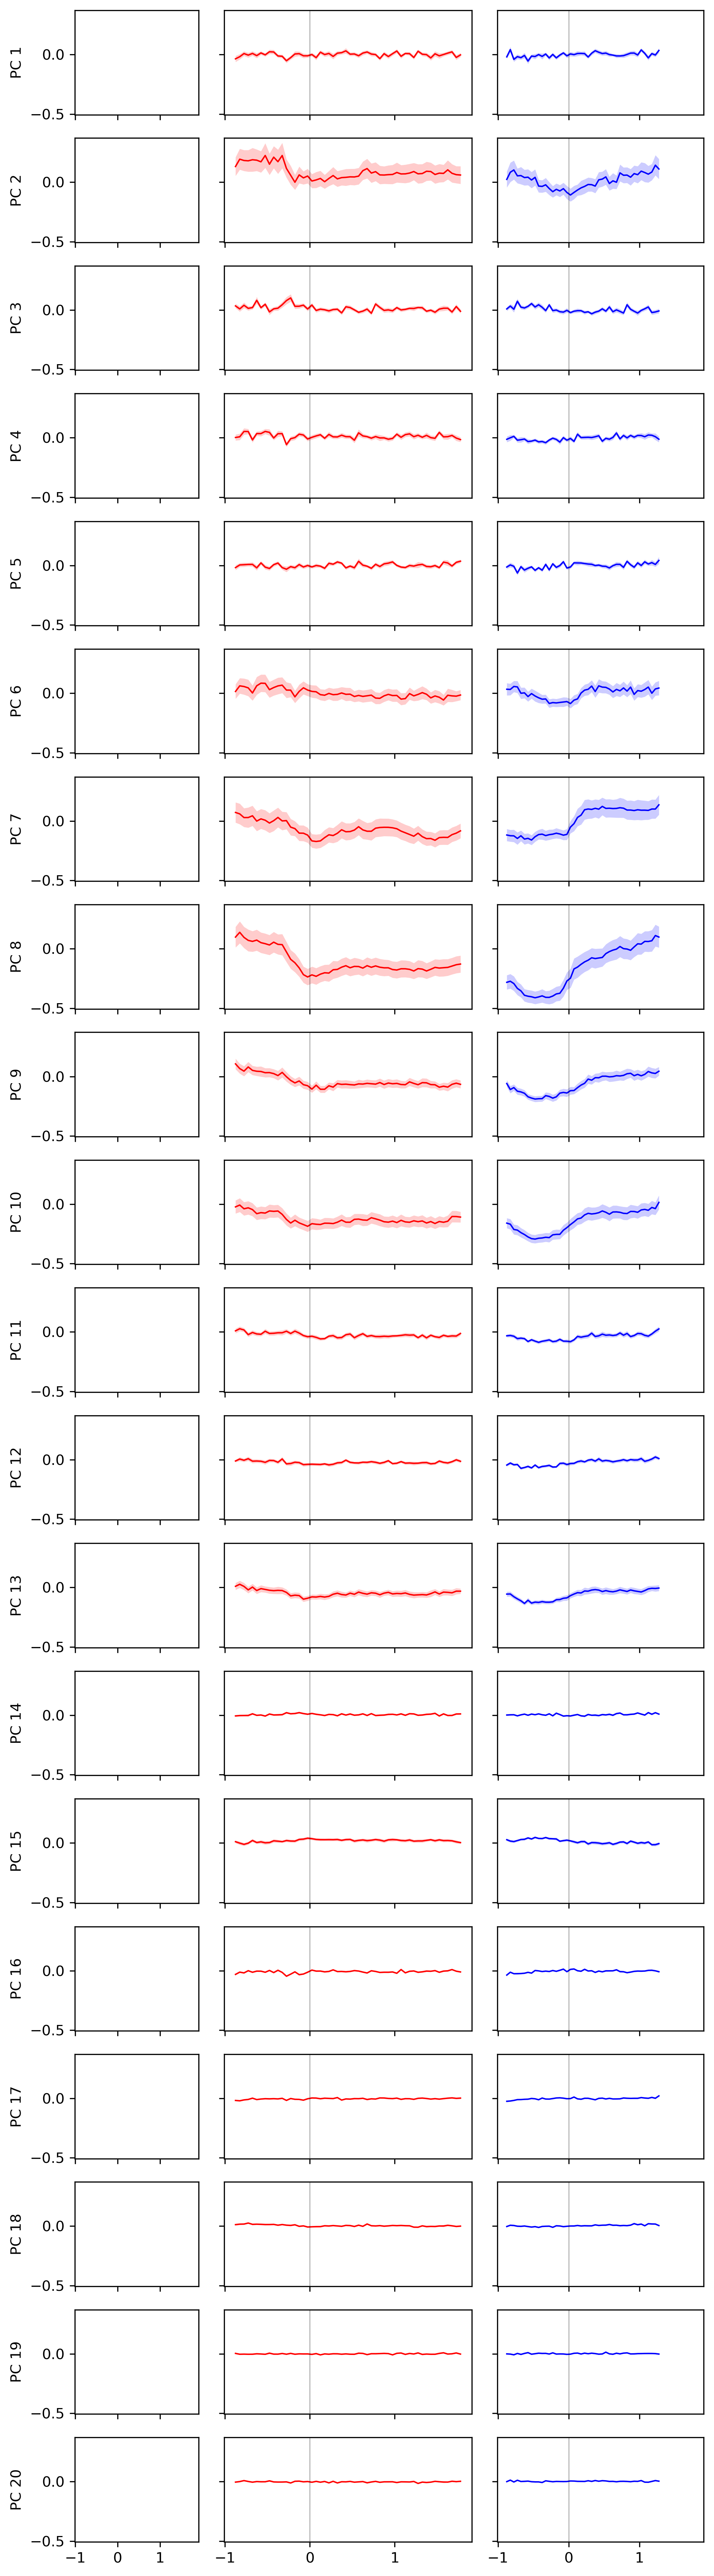

In [111]:
f, ax = plt.subplots(20, 3, figsize=(7,25), dpi=300, facecolor="white", gridspec_kw={"width_ratios":[1.5, 3, 2.5]}, sharex=True, sharey=True)
for pc_ix in range(20):
    pc_key = "PC_{}".format(pc_ix+1)
    ax[pc_ix, 0].set_ylabel("PC {}".format(pc_ix+1))
    vis_mean = np.mean(PC_mean_score_in_time["vis"][pc_key], axis=0)
    mot_mean = np.mean(PC_mean_score_in_time["mot"][pc_key], axis=0)
    vis_sem = np.std(PC_mean_score_in_time["vis"][pc_key], axis=0) / np.sqrt(36)
    mot_sem = np.std(PC_mean_score_in_time["mot"][pc_key], axis=0) / np.sqrt(36)

    ax[pc_ix, 1].plot(vis_time_plot, vis_mean, lw=1, c="red")
    ax[pc_ix, 1].fill_between(
        vis_time_plot, 
        vis_mean - vis_sem,
        vis_mean + vis_sem,
        lw=0, color="red", alpha=0.2
    )
    
    ax[pc_ix, 2].plot(mot_time_plot, mot_mean, lw=1, c="blue")
    ax[pc_ix, 2].fill_between(
        mot_time_plot, 
        mot_mean - mot_sem,
        mot_mean + mot_sem,
        lw=0, color="blue", alpha=0.2
    )
    
    ax[pc_ix, 1].axvline(0, lw=0.2, color="black")
    ax[pc_ix, 2].axvline(0, lw=0.2, color="black")

plt.tight_layout()